In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import metpy.interpolate as mpinterp
import metpy.calc as mpcalc

In [2]:
# DBZ Color Table: 
dbz_contour_levels = np.arange(0.,80.,5.)
href_refl_colors = ("#ffffff", "#00ffff", "#0080ff", "#0000ff", "#00ff00", "#00c000", "#008000", "#ffff00",
                    "#ffc000", "#ff8000", "#ff0000", "#c00000", "#800000", "#ff00ff", "#8d67cd", "#c0c0c0")

def oldNorm(var1, var2):
    if (var1.max() >= var2.max()):
        norm_max = var1.max()
    else:
        norm_max = var2.max()
    if (var1.min() <= var2.min()):
        norm_min = var1.min()
    else:
        norm_min = var2.min()
    norm = plt.Normalize(norm_min, norm_max)
    
    return(norm)

def var_minmax(*arg):
    var_max = max(arg)
    var_min = min(arg)
    return(var_max, var_min)

def label_plot(ax, var, hres, vres, level):
    ax.set_title(f'{var} - {level} - {hres}/{vres} - ' + str(hour * 0.5) + ' hour(s) after initiation')
    ax.set_xlabel('West-East Distance (km)')
    ax.set_ylabel('South-North Distance (km)')
    ax.minorticks_on()
    ax.grid(which='major', color='gray', alpha=0.5, linestyle='dotted', linewidth=2.)
    
    return(ax)

# Define functions
def open_ds(bubble, wind, hres, vres):
    filepath = (f'/glade/scratch/sluthi/cm1_output/{bubble}_bubble/{wind}/{hres}dx_{vres}/cm1out_{hres}dx_{vres}.nc')
    return xr.open_dataset(filepath)

def linspace_covering(range_source, npts):
    return np.linspace(range_source.values[0], range_source.values[-1], npts)

In [3]:
cm1_3km50dz = open_ds('multi', 'multicell', '3km', '50vlvls')
cm1_1km50dz = open_ds('multi', 'multicell', '1km', '50vlvls')

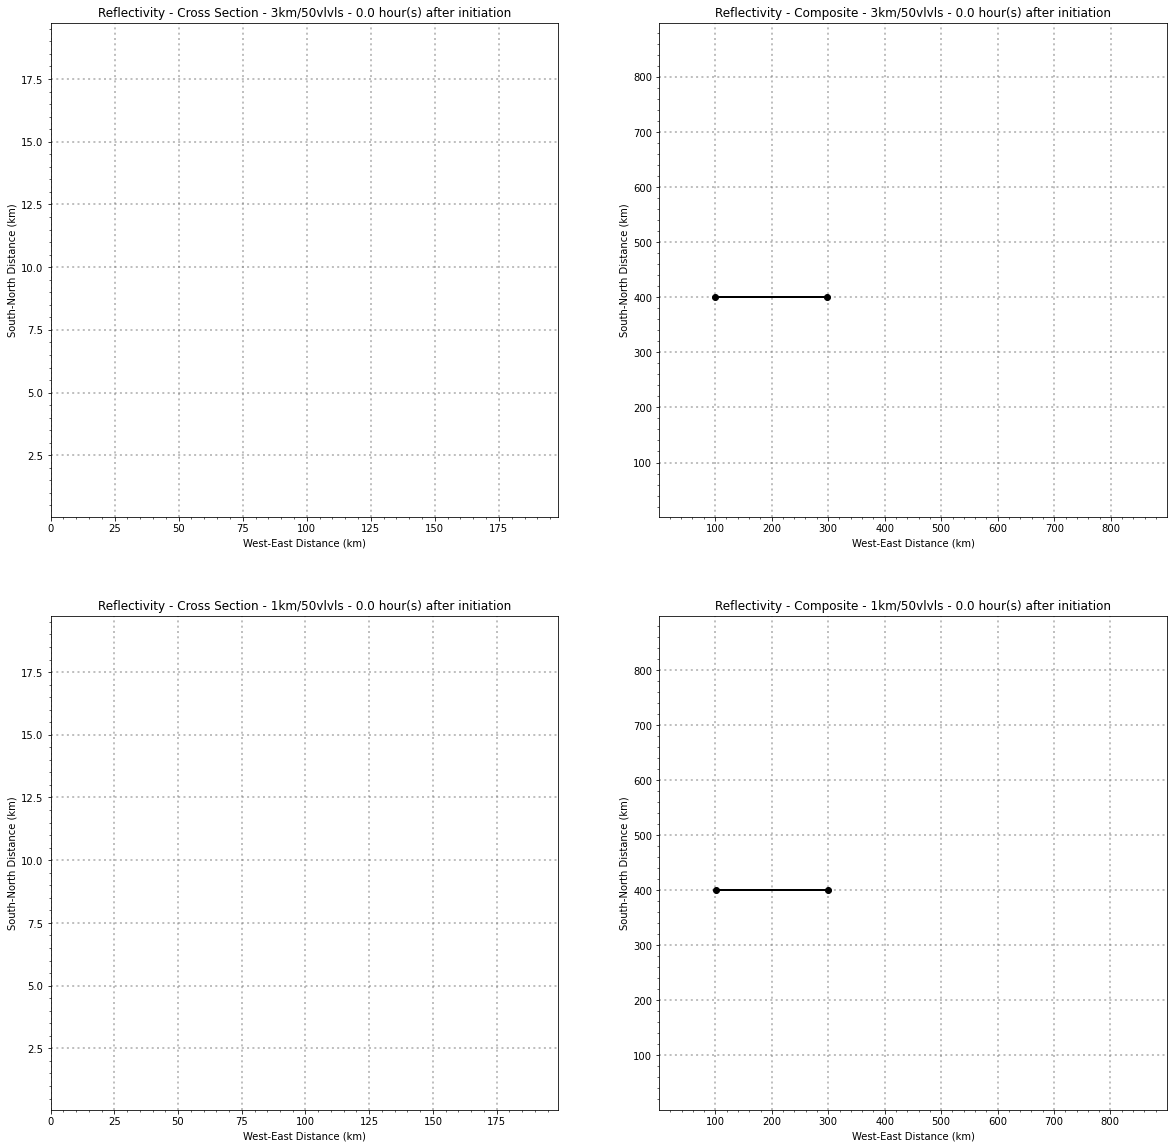

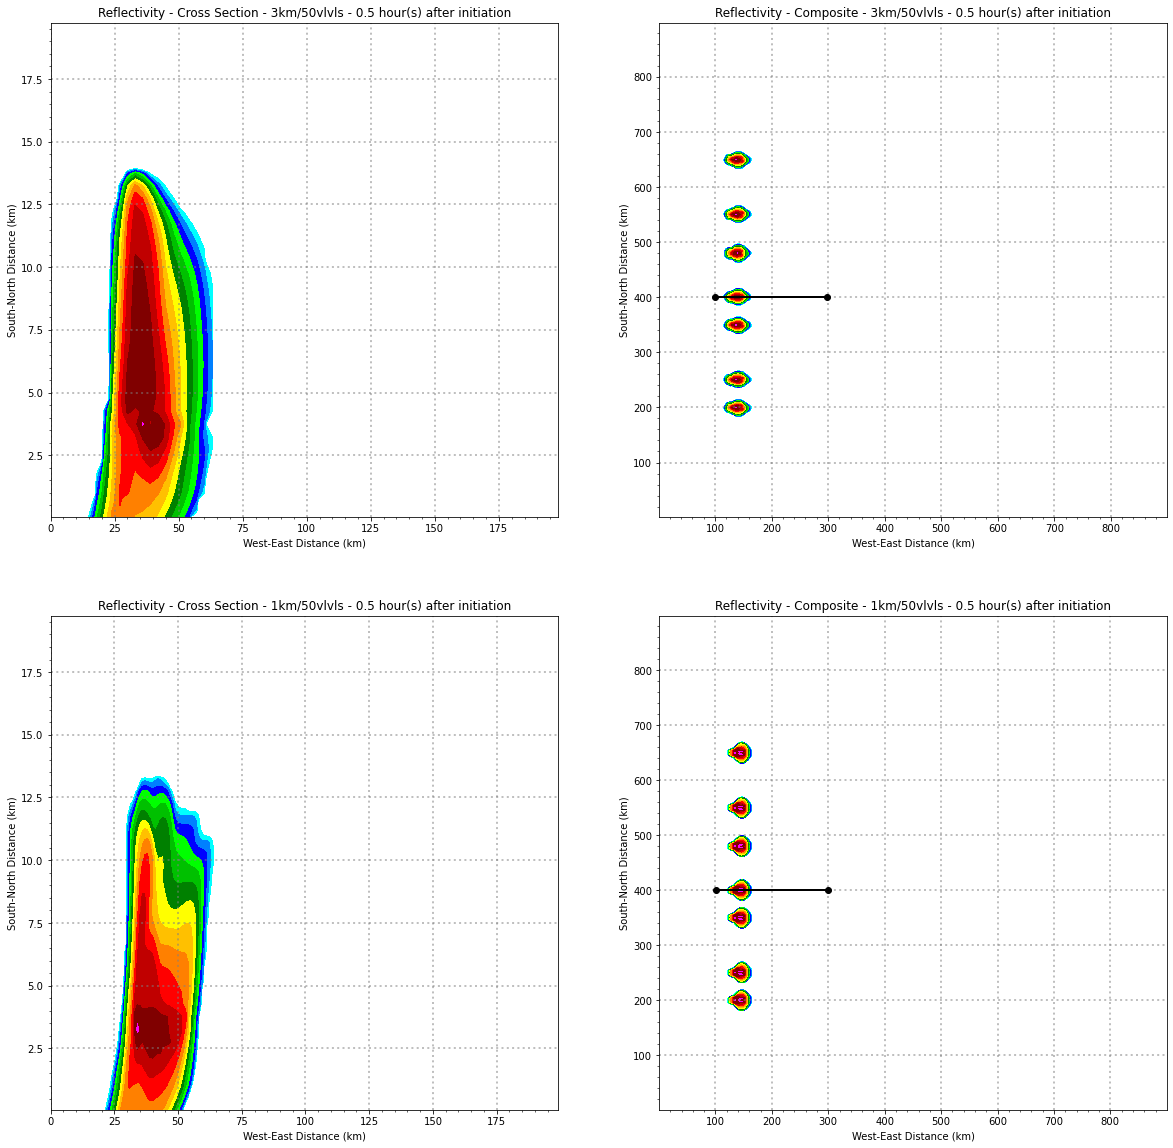

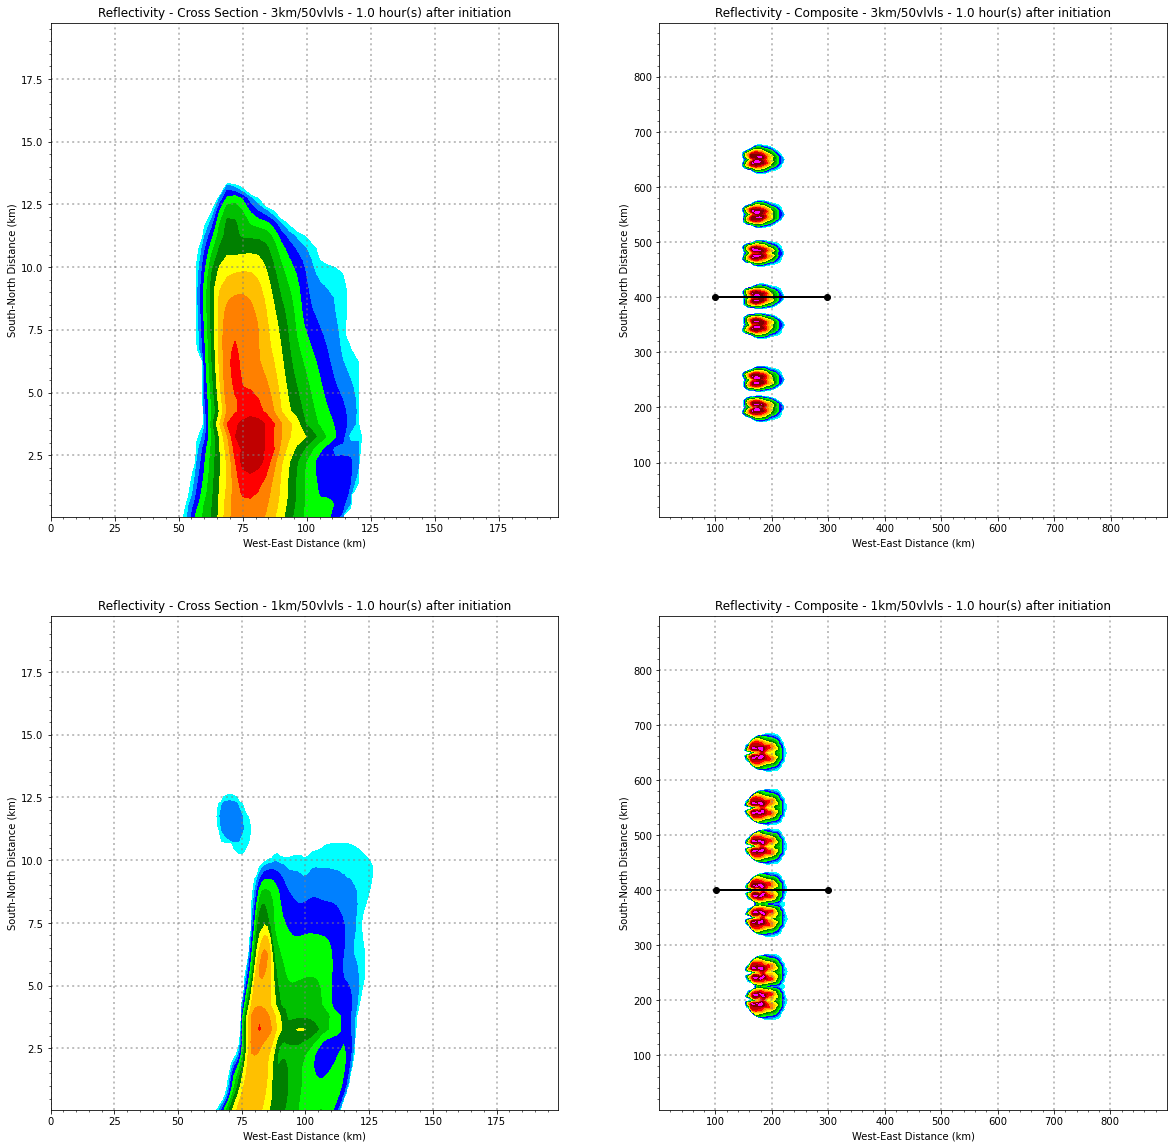

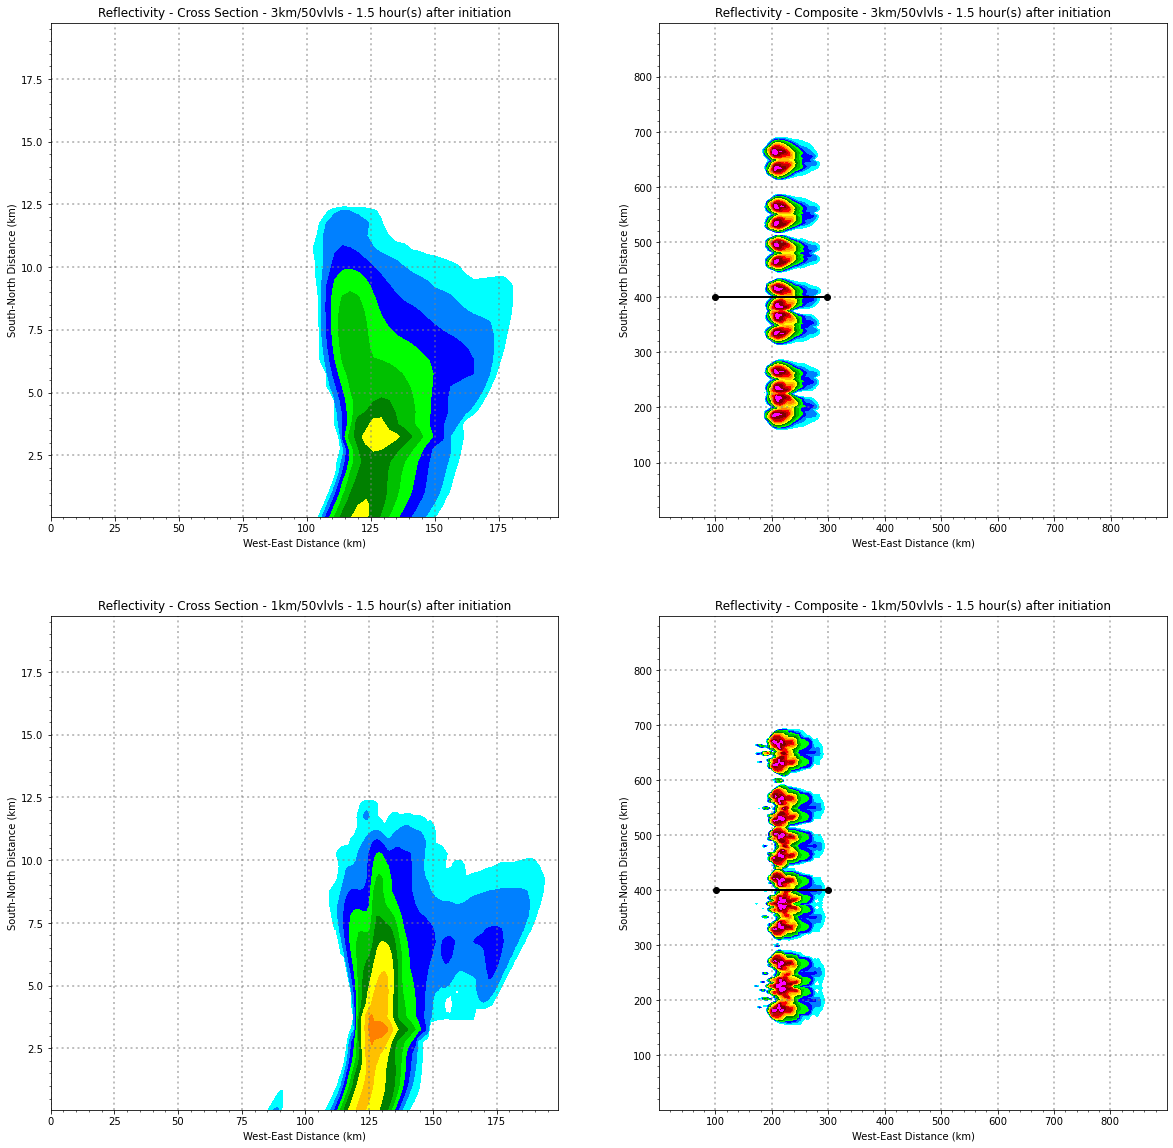

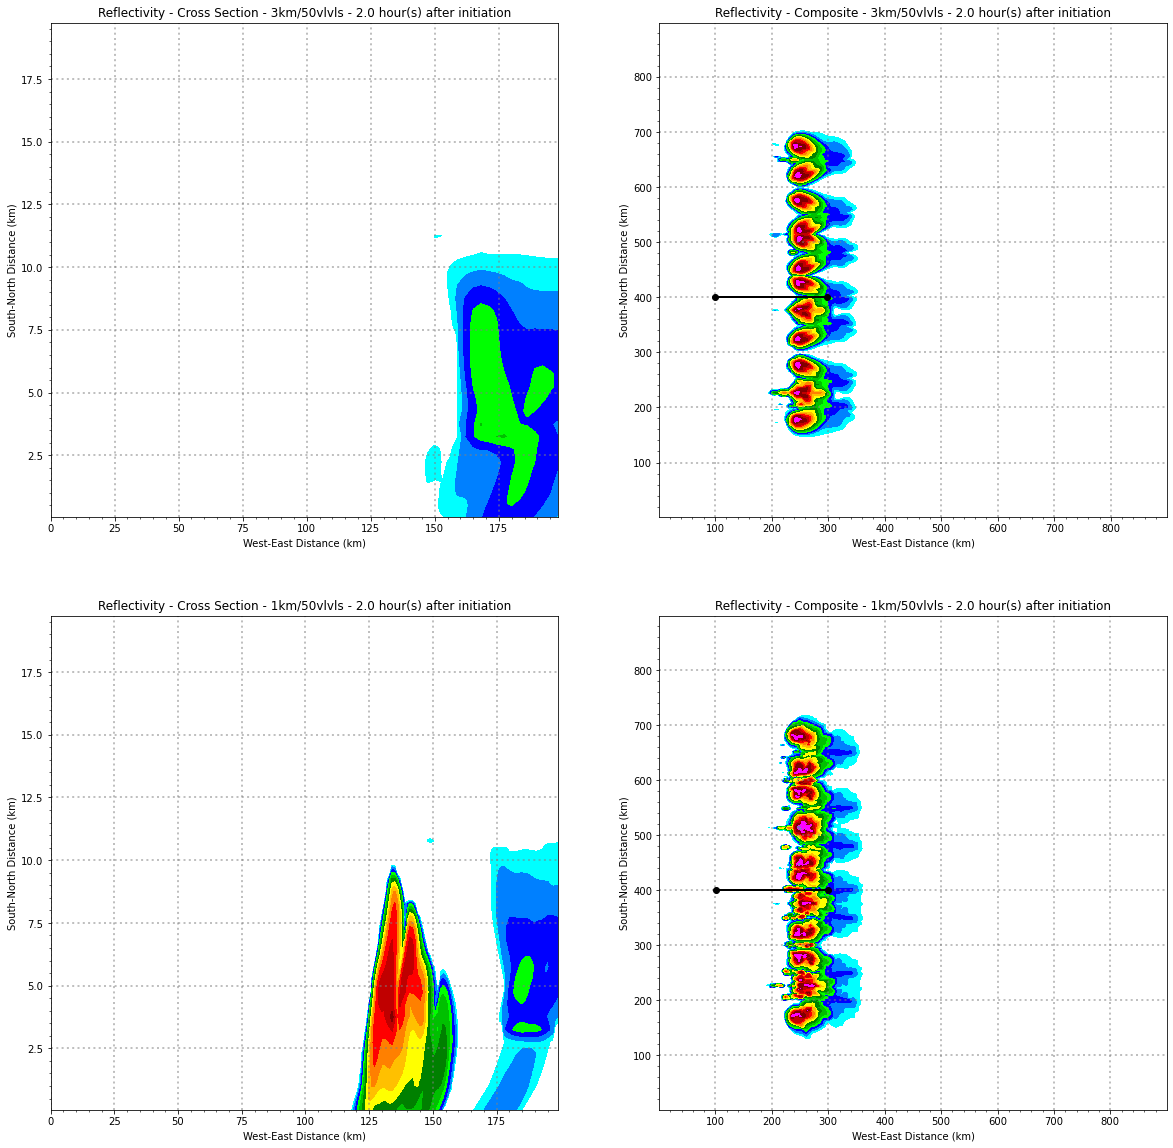

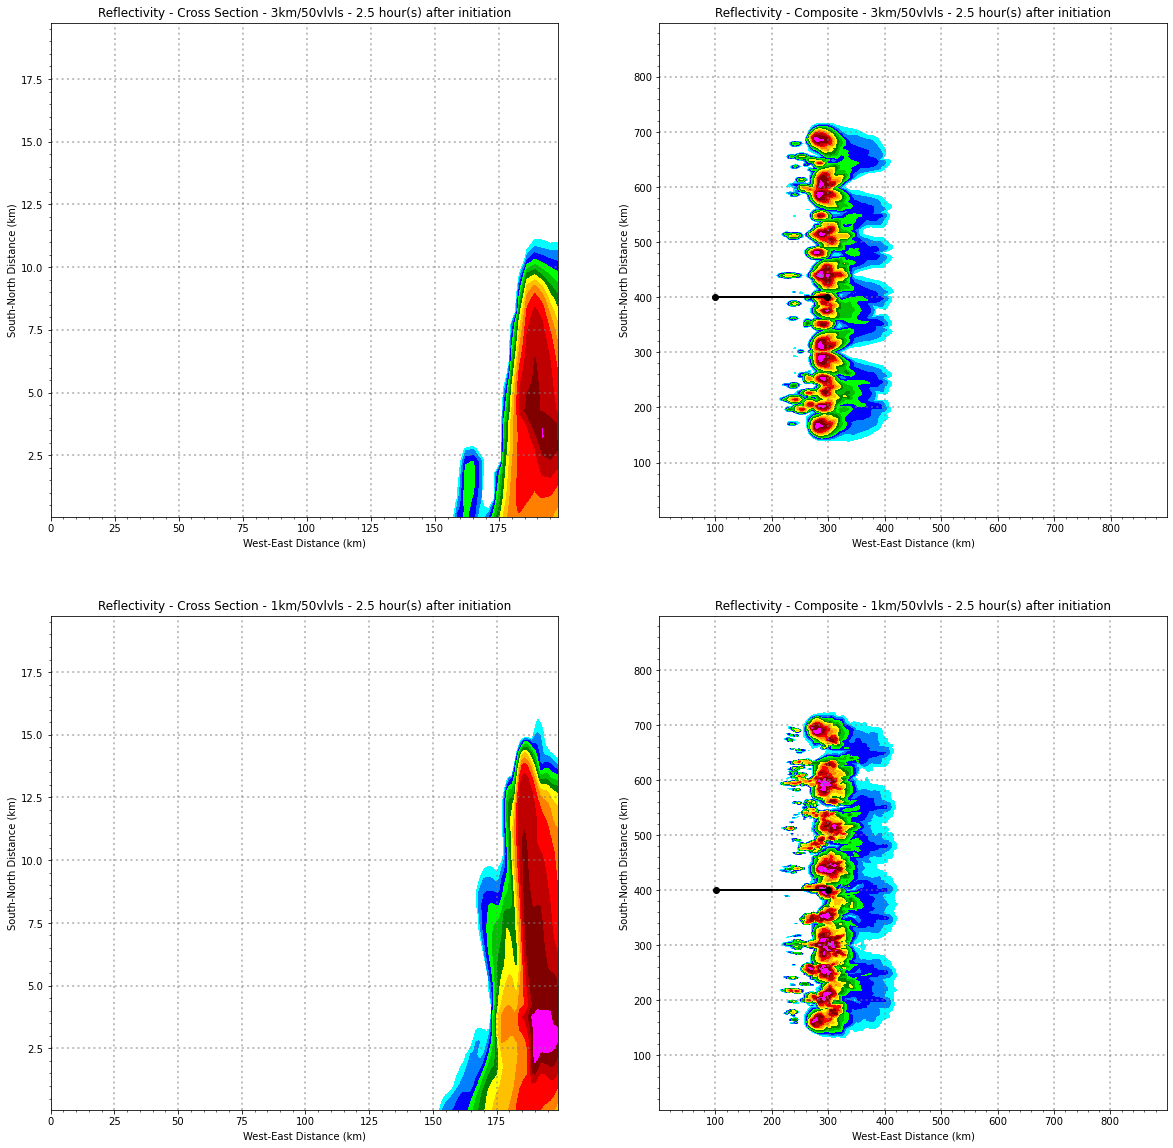

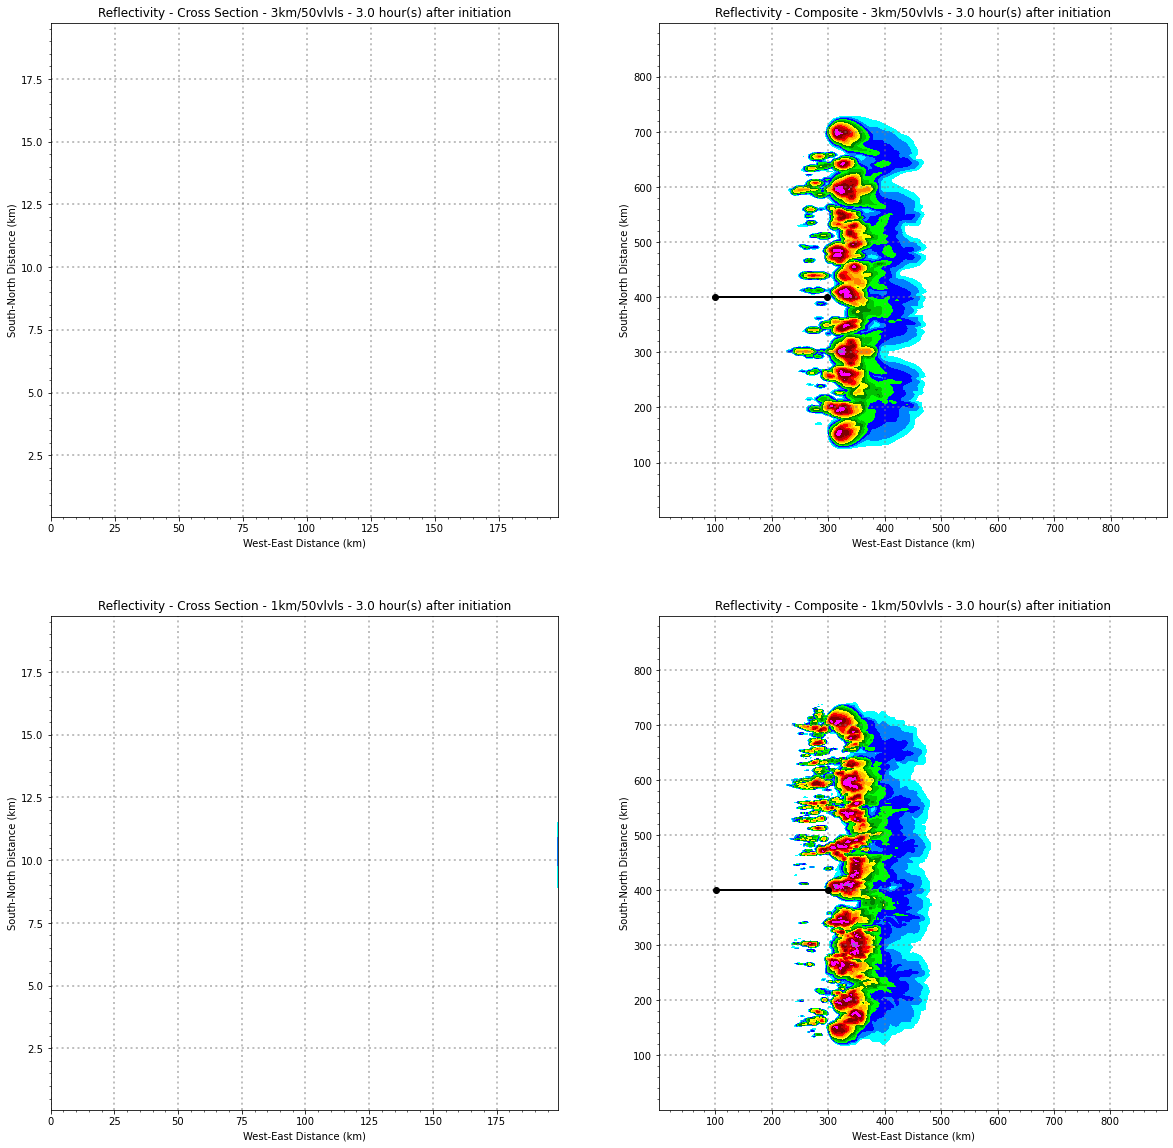

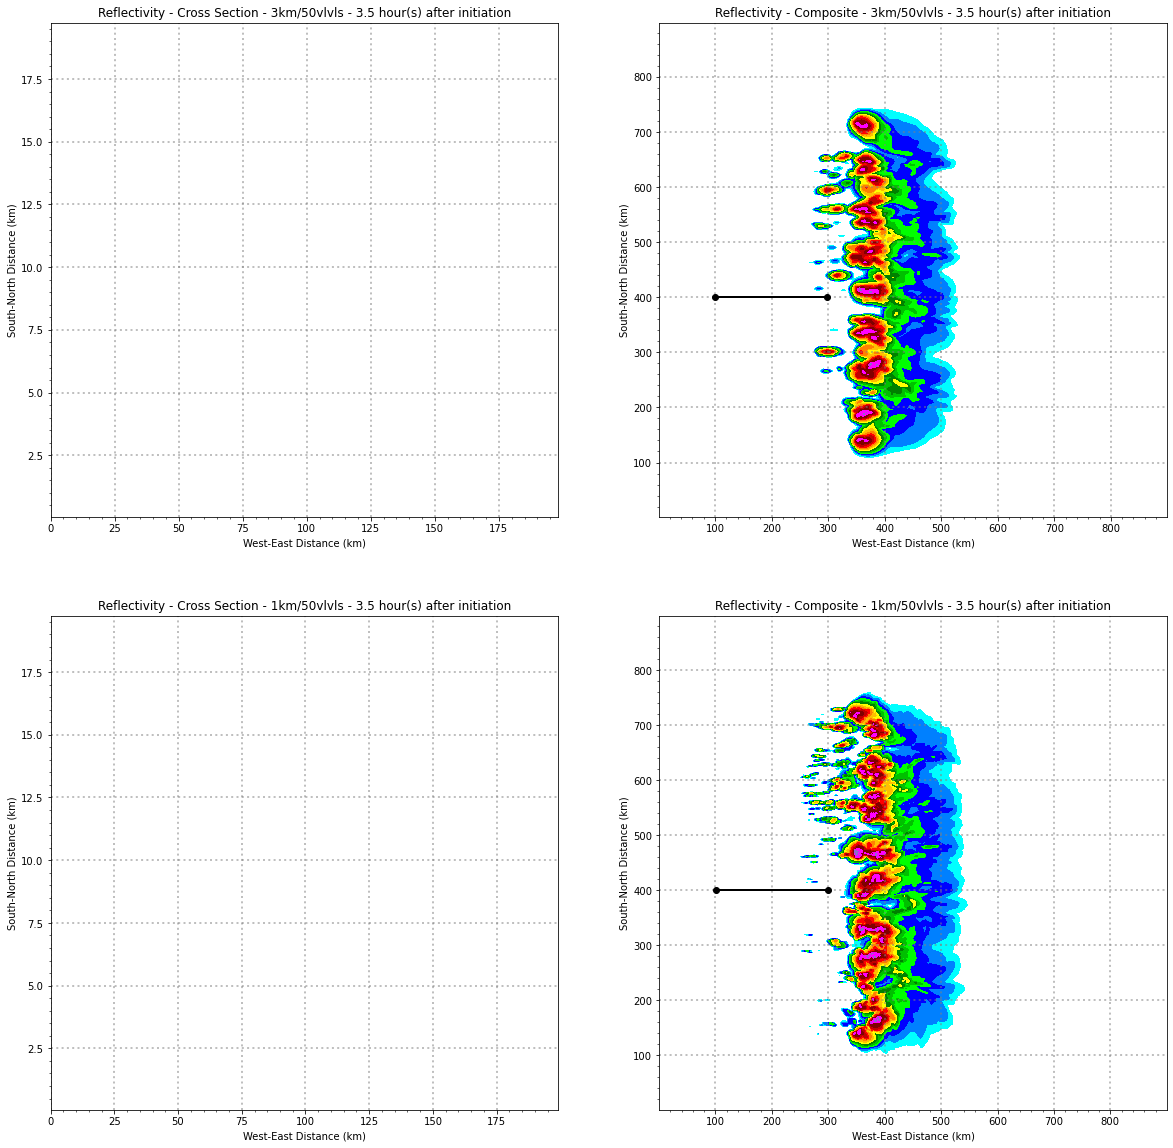

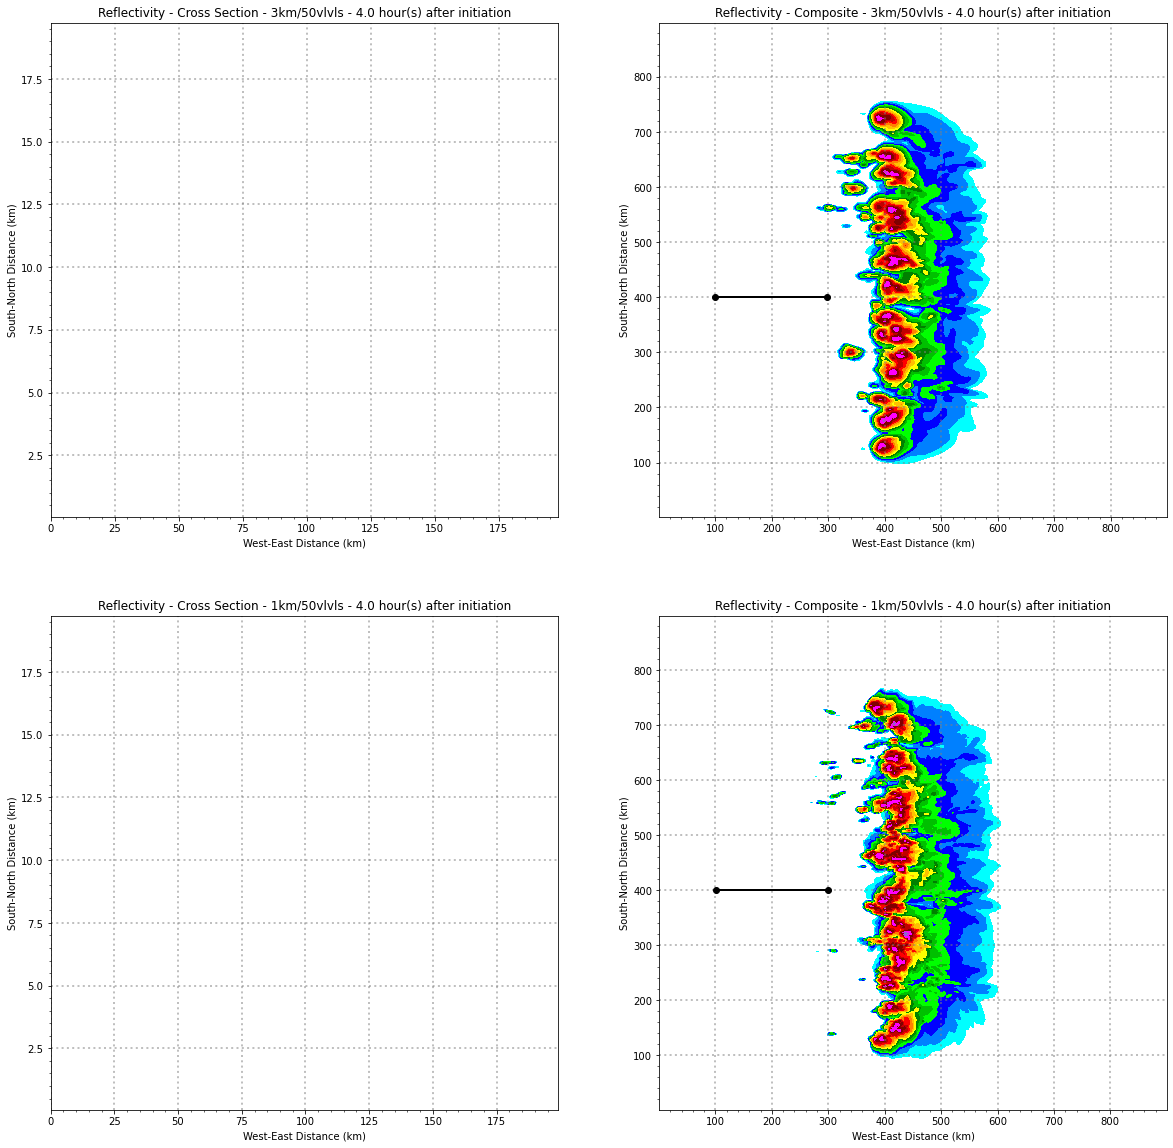

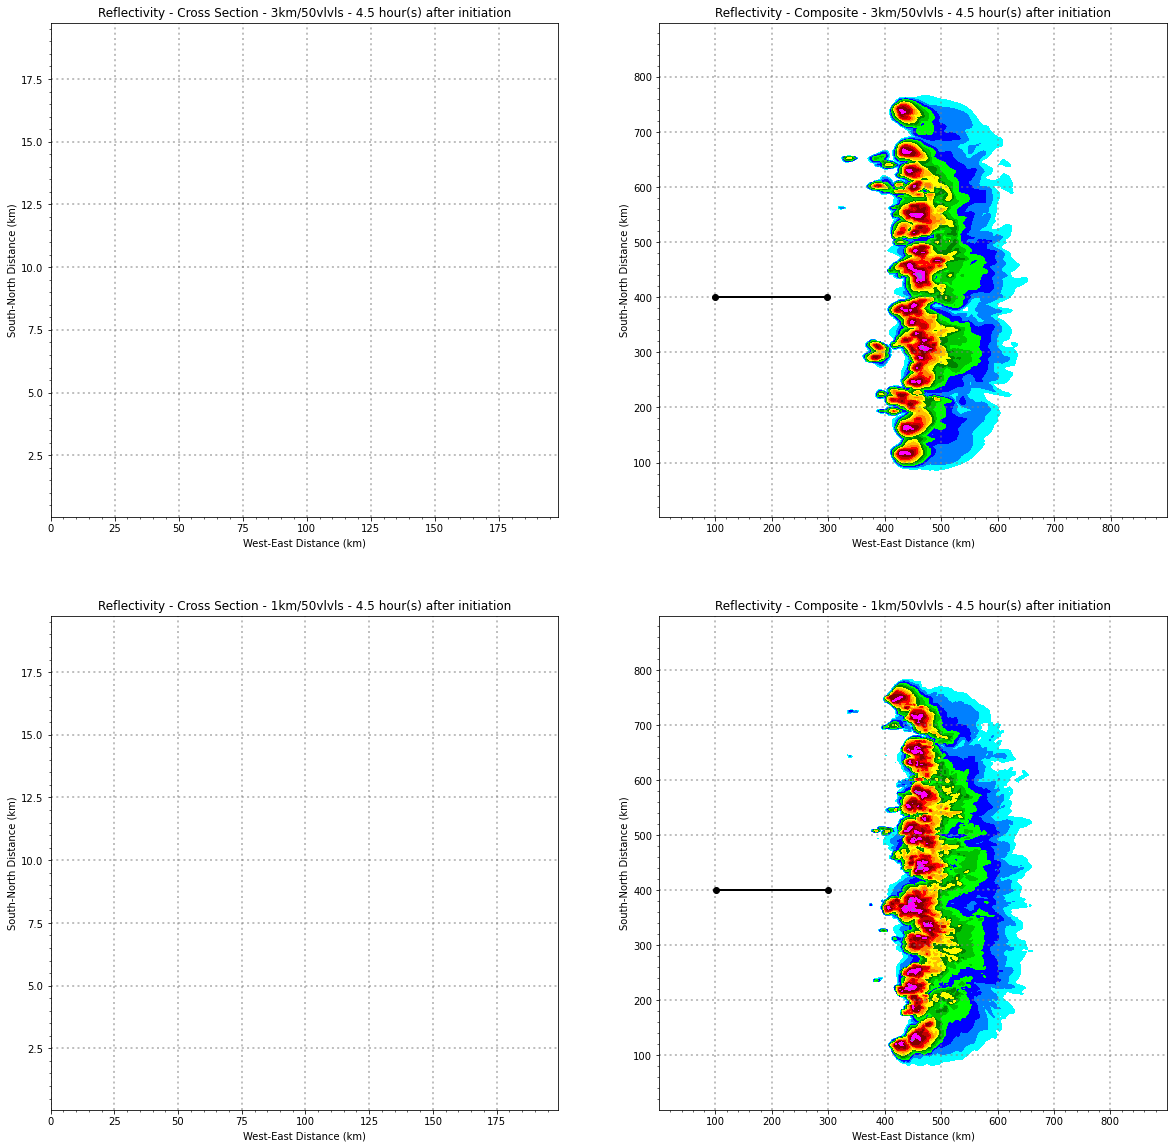

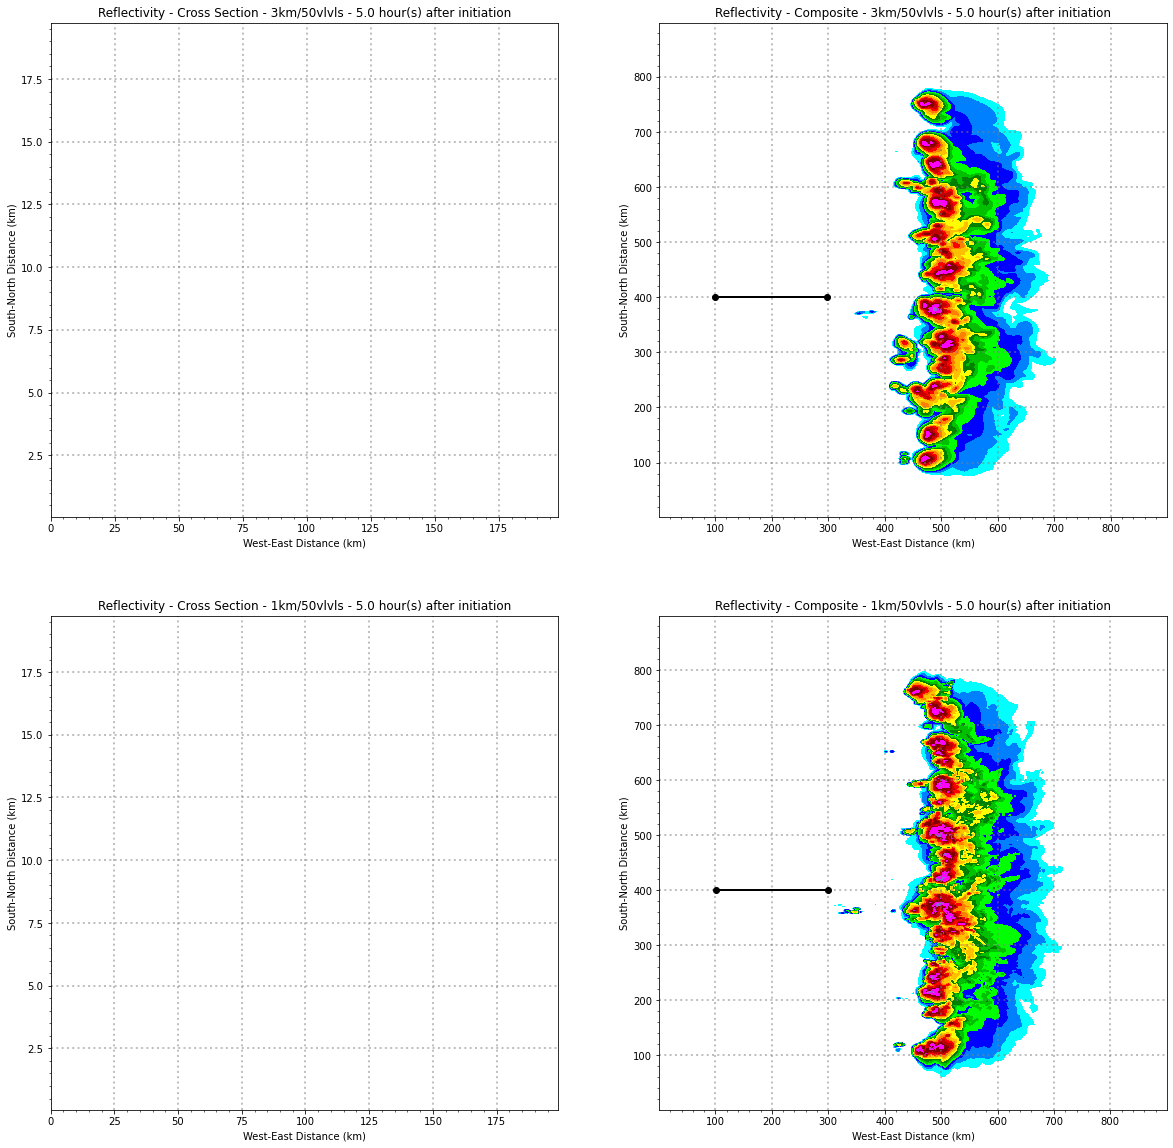

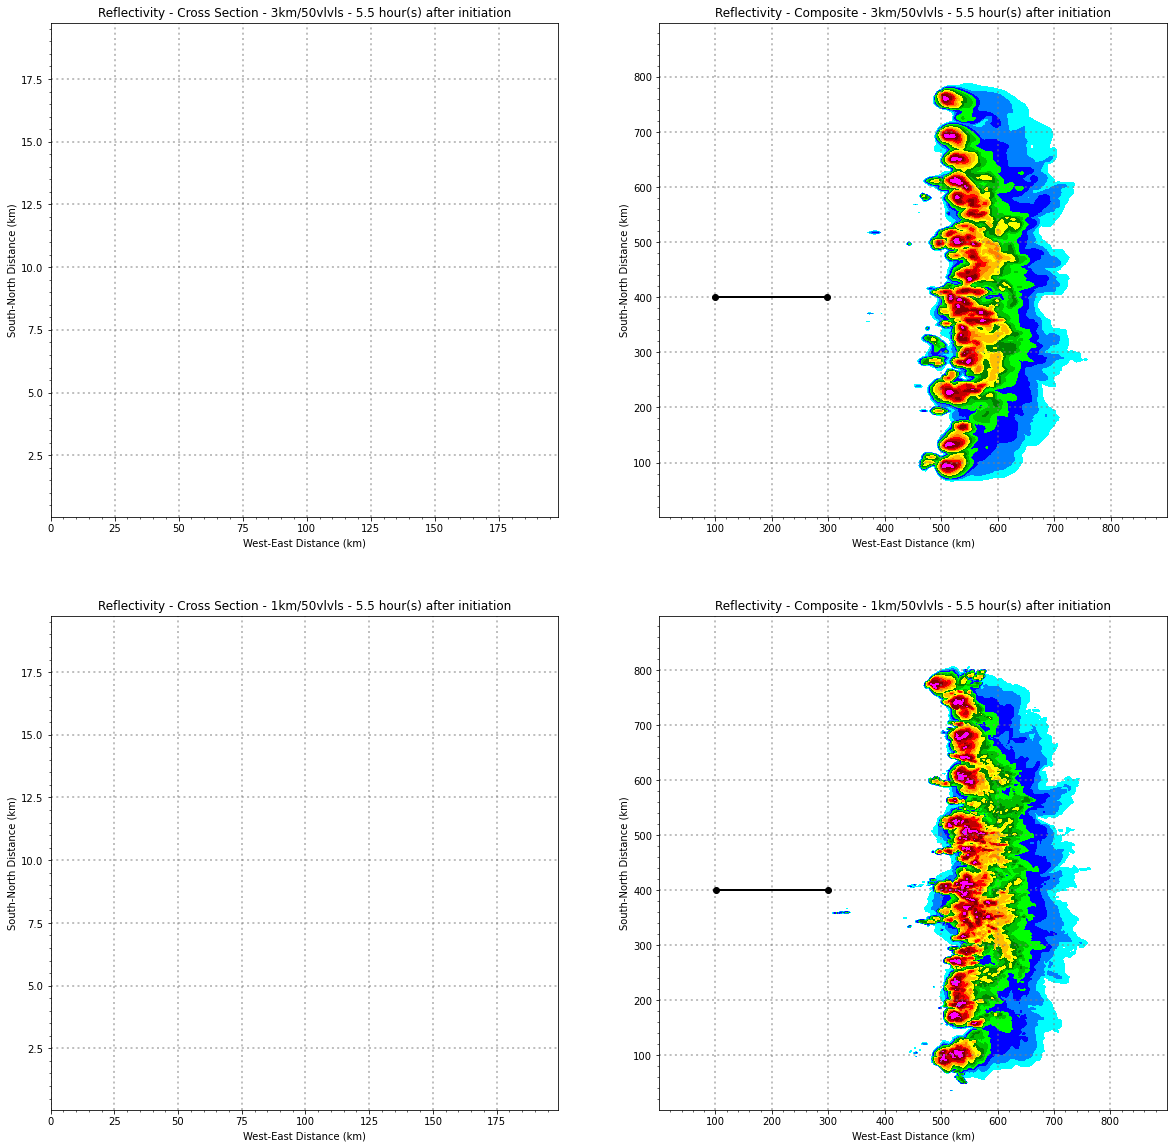

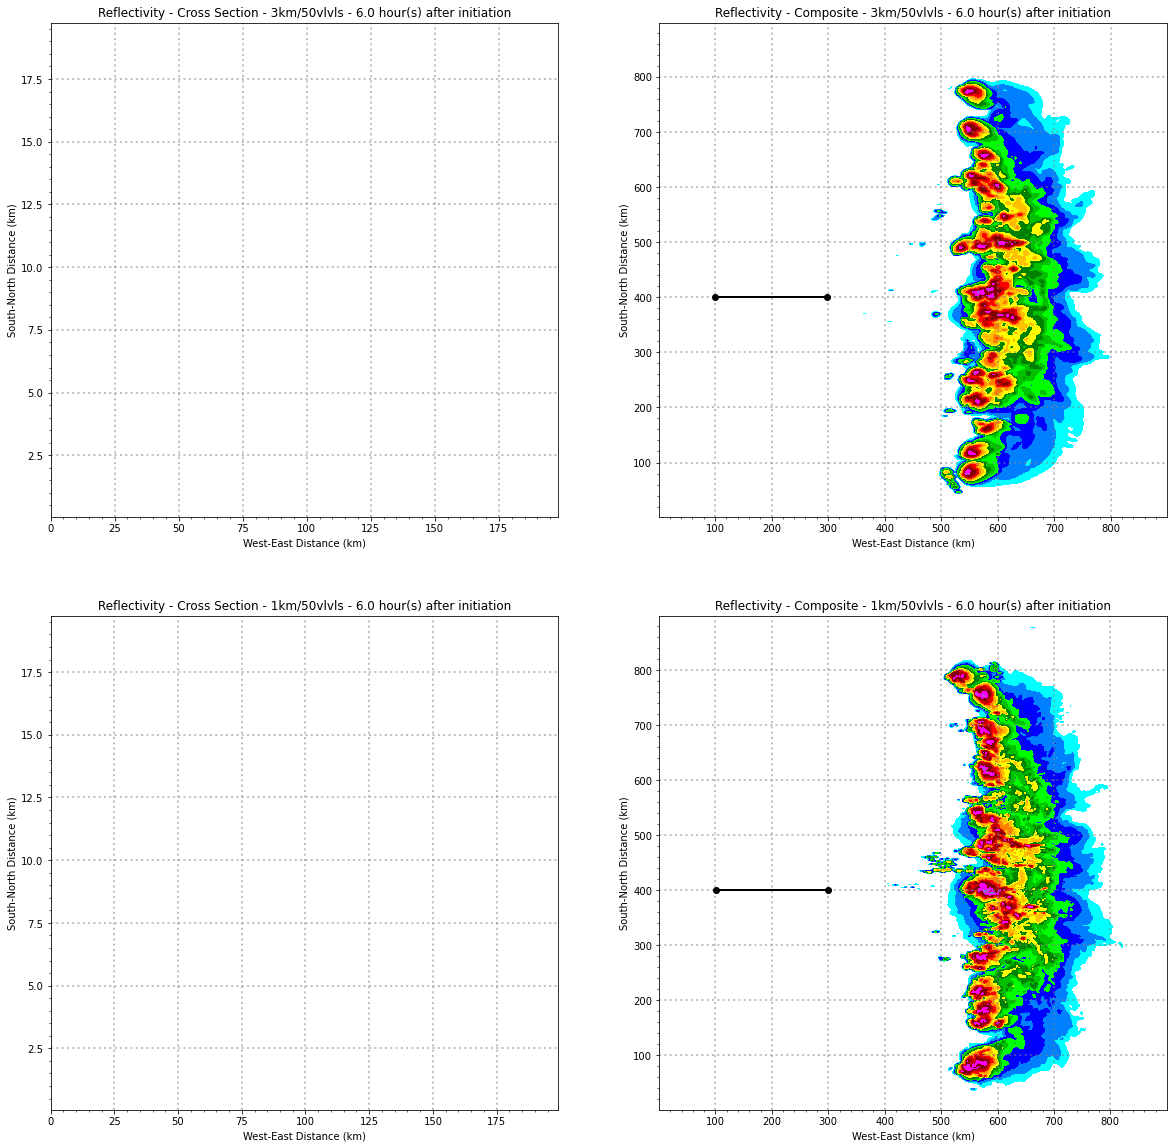

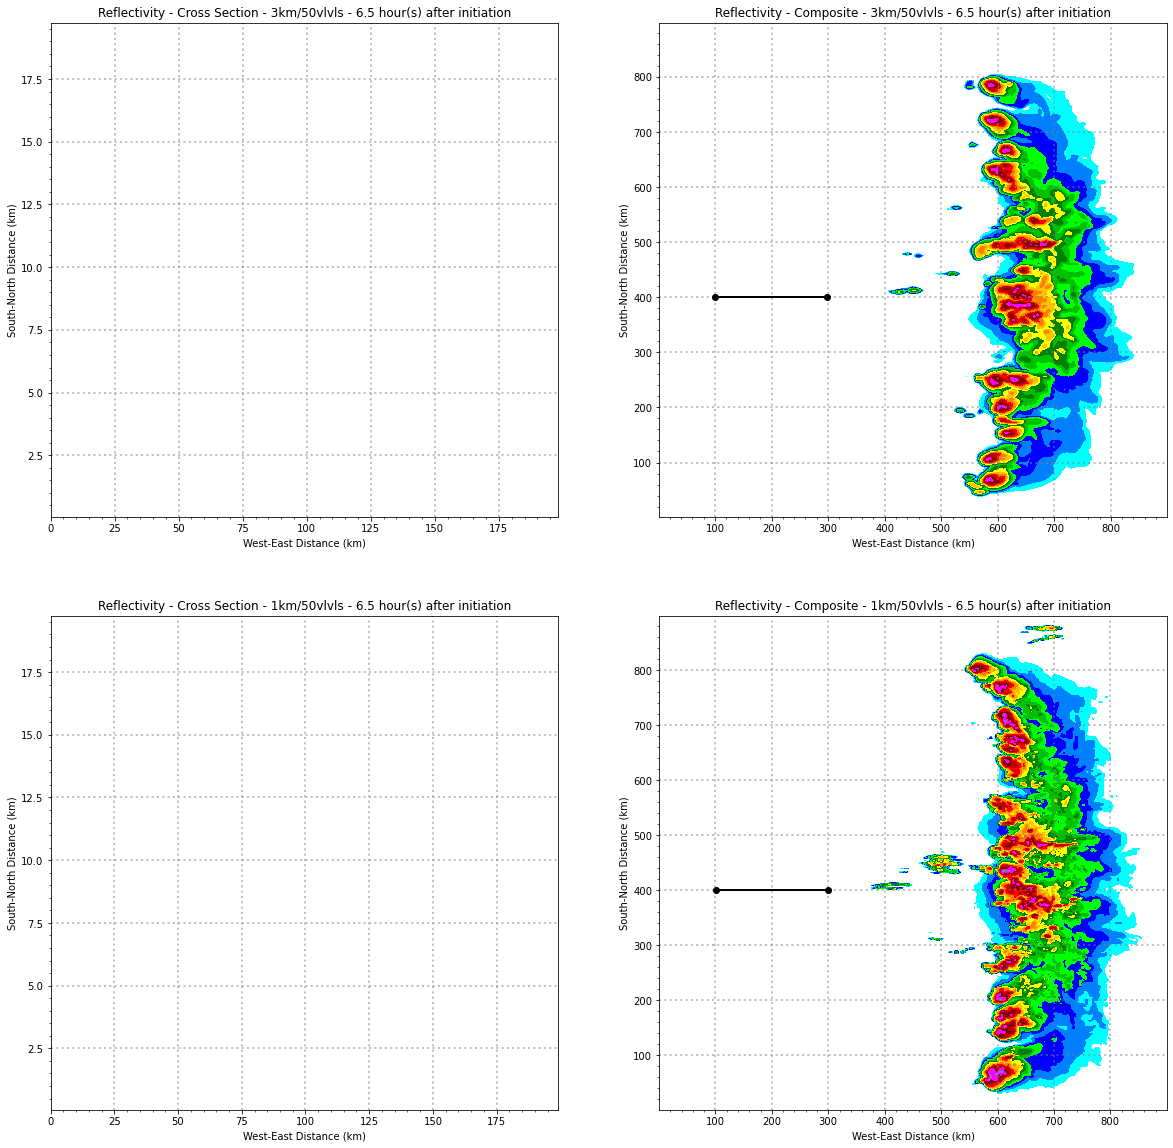

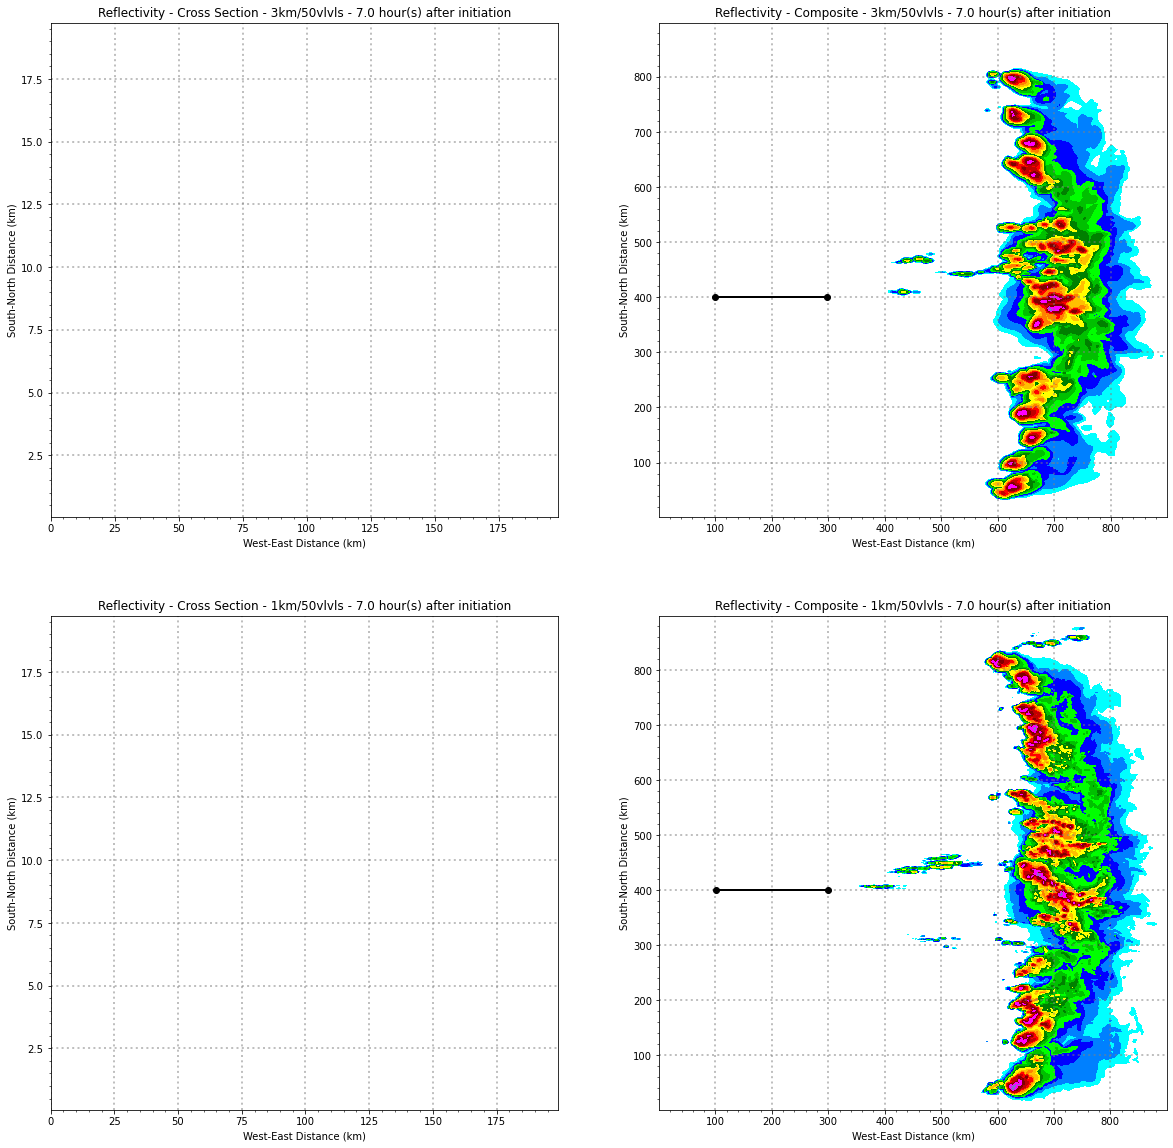

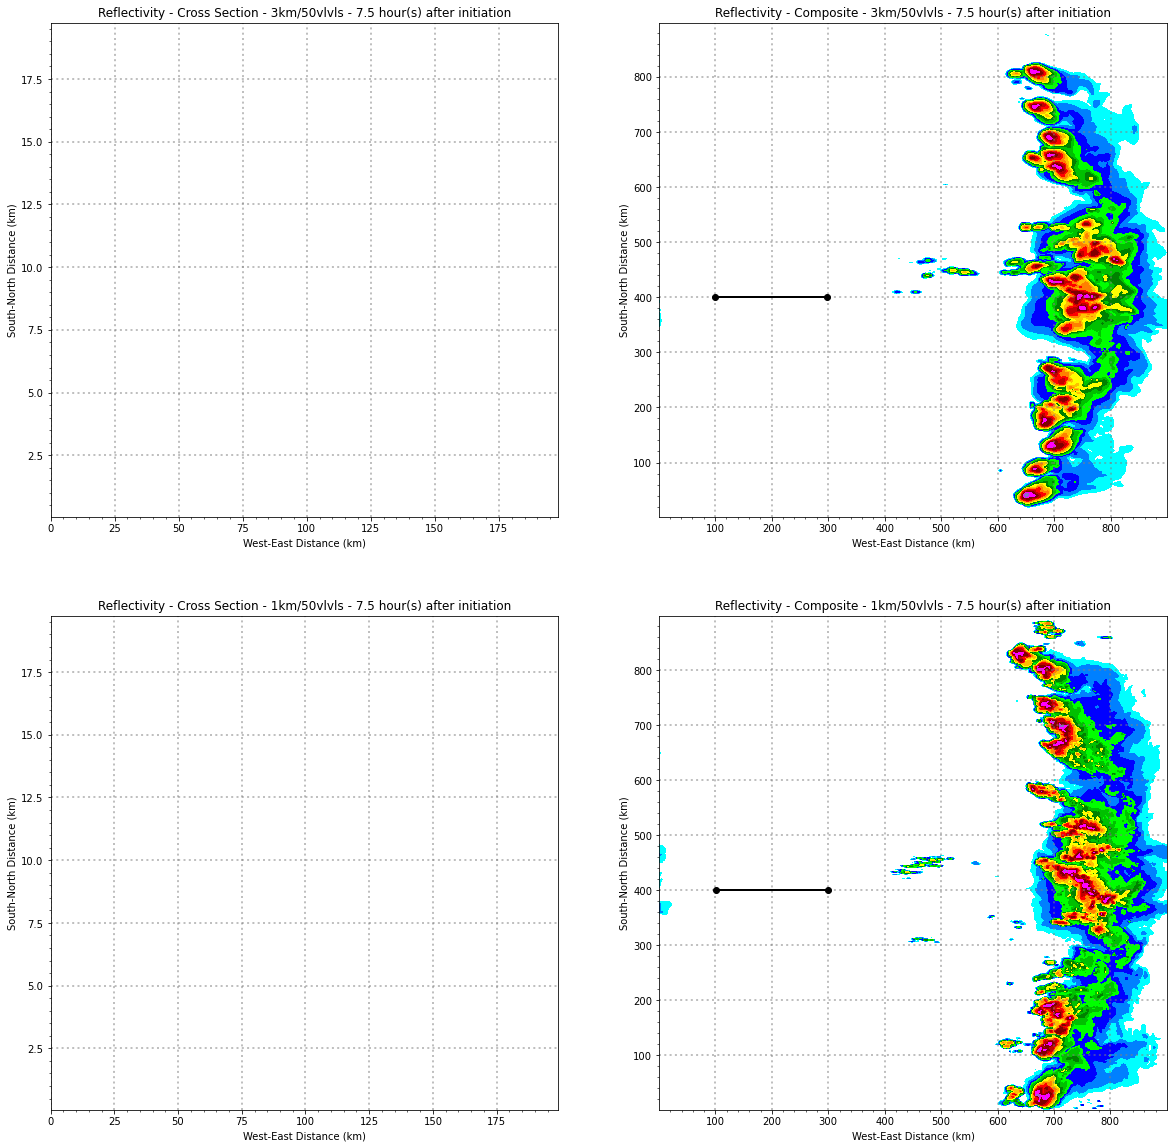

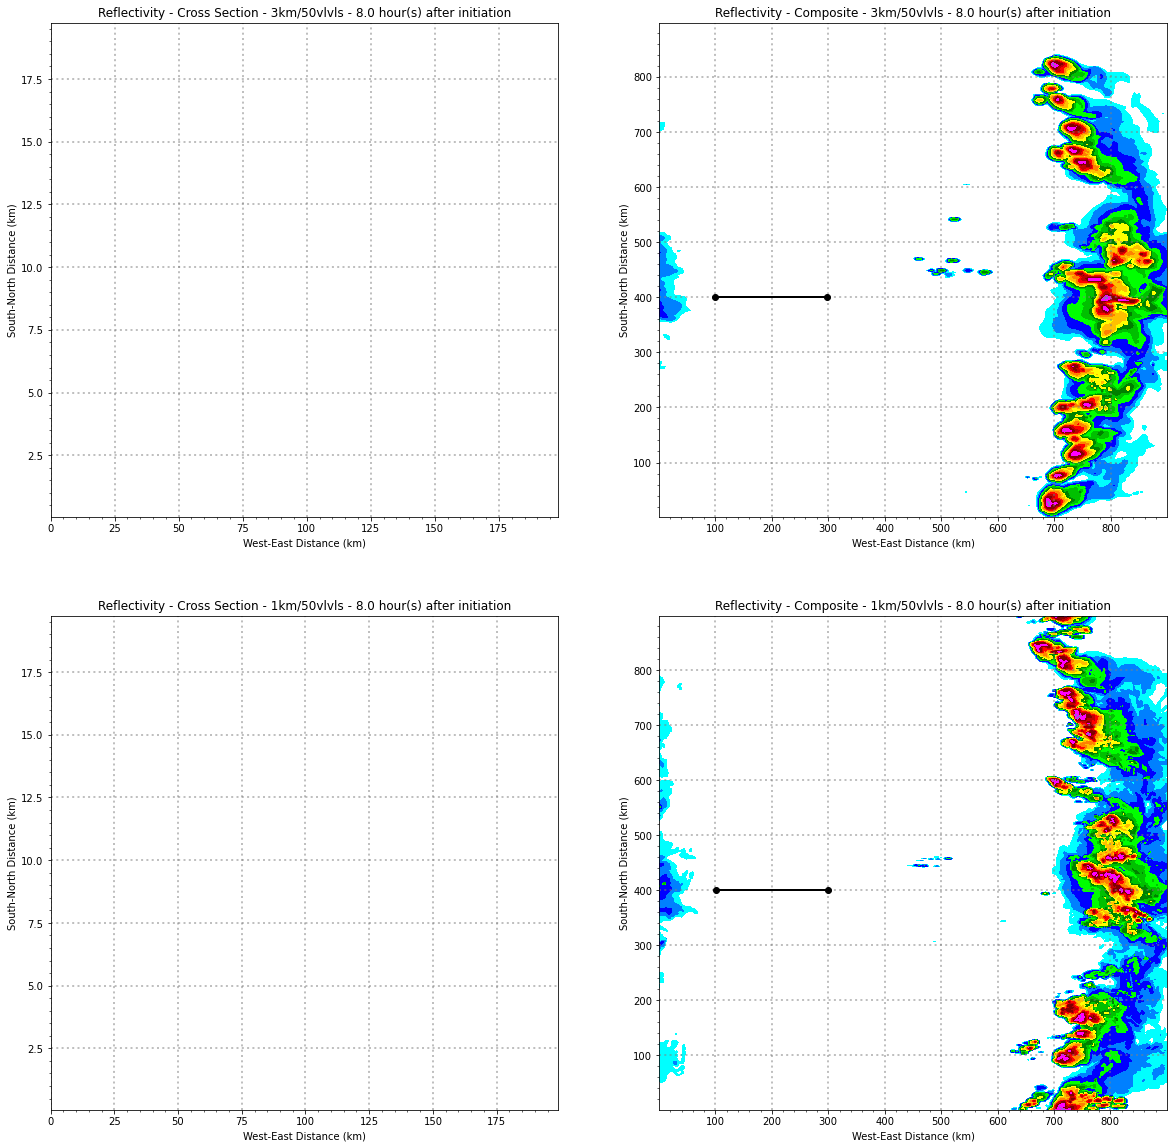

In [4]:
for hour in range(0, 17, 1):
    
    cref_3km = cm1_3km50dz['dbz']
    cref_1km = cm1_1km50dz['dbz']
    crefreal_3km = cm1_3km50dz['cref']
    crefreal_1km = cm1_1km50dz['cref']
    
    # Adjust values as needed (noting that these define closed intervals for usbsetting,
    # so you may or may not end up with these as exact endpoints
    x1_3km, x2_3km = 100, 300
    y1_3km, y2_3km = 400, 401
    x1_1km, x2_1km = 100, 300
    y1_1km, y2_1km = 400, 401
    
    # Range sources for 3km and 1km
    x_range_source_3km = cref_3km.metpy.x.metpy.sel(x=slice(x1_3km, x2_3km))
    y_range_source_3km = cref_3km.metpy.y.metpy.sel(y=slice(y1_3km, y2_3km))
    x_range_source_1km = cref_1km.metpy.x.metpy.sel(x=slice(x1_1km, x2_1km))
    y_range_source_1km = cref_1km.metpy.y.metpy.sel(y=slice(y1_1km, y2_1km))
    
    if len(x_range_source_3km) > len(y_range_source_3km):
        x_range_target_3km = x_range_source_3km.values
        y_range_target_3km = linspace_covering(y_range_source_3km, len(x_range_source_3km))
    else:
        x_range_target_3km = linspace_covering(x_range_source_3km, len(y_range_source_3km))
        y_range_target_3km = y_range_source_3km.values
        
    if len(x_range_source_1km) > len(y_range_source_1km):
        x_range_target_1km = x_range_source_1km.values
        y_range_target_1km = linspace_covering(y_range_source_1km, len(x_range_source_1km))
    else:
        x_range_target_1km = linspace_covering(x_range_source_1km, len(y_range_source_1km))
        y_range_target_1km = y_range_source13km.values
        
    points_3km = np.stack([x_range_target_3km, y_range_target_3km], axis=1)
    points_1km = np.stack([x_range_target_1km, y_range_target_1km], axis=1)
    
    cross_var_3km = mpinterp.interpolate_to_slice(cref_3km[hour], points=points_3km, interp_type='linear')
    cross_var_1km = mpinterp.interpolate_to_slice(cref_1km[hour], points=points_1km, interp_type='linear')
    
    horizontal_dels_3km = np.hypot(cross_var_3km.metpy.x - cross_var_3km.metpy.x.min(),
                                   cross_var_3km.metpy.y - cross_var_3km.metpy.y.min()).rename('distance')
    
    horizontal_dels_1km = np.hypot(cross_var_1km.metpy.x - cross_var_1km.metpy.x.min(),
                                   cross_var_1km.metpy.y - cross_var_1km.metpy.y.min()).rename('distance')
    
    cenx1_3km = cross_var_3km.metpy.x.min().item()
    cenx2_3km = cross_var_3km.metpy.x.max().item()
    ceny1_3km = cross_var_3km.metpy.y.min().item()
    ceny2_3km = cross_var_3km.metpy.y.max().item()
    
    cenx1_1km = cross_var_1km.metpy.x.min().item()
    cenx2_1km = cross_var_1km.metpy.x.max().item()
    ceny1_1km = cross_var_1km.metpy.y.min().item()
    ceny2_1km = cross_var_1km.metpy.y.max().item()
    
    fig = plt.figure(figsize=(20,20))
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 2, 3)
    ax4 = plt.subplot(2, 2, 4)
    
    xsec_contourf_3km = ax1.contourf(horizontal_dels_3km, cross_var_3km.metpy.vertical, cross_var_3km, levels=dbz_contour_levels, colors=href_refl_colors)
    cref_contourf_3km = ax2.contourf(cref_3km.metpy.x, cref_3km.metpy.y, crefreal_3km[hour], levels=dbz_contour_levels, colors=href_refl_colors)
    xsec_contourf_1km = ax3.contourf(horizontal_dels_1km, cross_var_1km.metpy.vertical, cross_var_1km, levels=dbz_contour_levels, colors=href_refl_colors)
    cref_contourf_1km = ax4.contourf(cref_1km.metpy.x, cref_1km.metpy.y, crefreal_1km[hour], levels=dbz_contour_levels, colors=href_refl_colors)
    
    ax2.plot([cenx1_3km, cenx2_3km], [ceny1_3km, ceny2_3km], c='k', marker='o', linewidth=2., zorder=10)
    ax4.plot([cenx1_1km, cenx2_1km], [ceny1_1km, ceny2_1km], c='k', marker='o', linewidth=2., zorder=10)
    
    label_plot(ax1, 'Reflectivity', '3km', '50vlvls', 'Cross Section')
    label_plot(ax2, 'Reflectivity', '3km', '50vlvls', 'Composite')
    label_plot(ax3, 'Reflectivity', '1km', '50vlvls', 'Cross Section')
    label_plot(ax4, 'Reflectivity', '1km', '50vlvls', 'Composite')
    
    plt.show()

In [ ]:
for hour in range(0, 17, 1):
    
    cref_3km = cm1_3km50dz['dbz']
    cref_1km = cm1_1km50dz['dbz']
    crefreal_3km = cm1_3km50dz['cref']
    crefreal_1km = cm1_1km50dz['cref']
    
    # Adjust values as needed (noting that these define closed intervals for usbsetting,
    # so you may or may not end up with these as exact endpoints
    x1_3km, x2_3km = 100, 300
    y1_3km, y2_3km = 400, 401
    x1_1km, x2_1km = 100, 300
    y1_1km, y2_1km = 400, 401
    
    # Range sources for 3km and 1km
    x_range_source_3km = cref_3km.metpy.x.metpy.sel(x=slice(x1_3km, x2_3km))
    y_range_source_3km = cref_3km.metpy.y.metpy.sel(y=slice(y1_3km, y2_3km))
    x_range_source_1km = cref_1km.metpy.x.metpy.sel(x=slice(x1_1km, x2_1km))
    y_range_source_1km = cref_1km.metpy.y.metpy.sel(y=slice(y1_1km, y2_1km))
    
    if len(x_range_source_3km) > len(y_range_source_3km):
        x_range_target_3km = x_range_source_3km.values
        y_range_target_3km = linspace_covering(y_range_source_3km, len(x_range_source_3km))
    else:
        x_range_target_3km = linspace_covering(x_range_source_3km, len(y_range_source_3km))
        y_range_target_3km = y_range_source_3km.values
        
    if len(x_range_source_1km) > len(y_range_source_1km):
        x_range_target_1km = x_range_source_1km.values
        y_range_target_1km = linspace_covering(y_range_source_1km, len(x_range_source_1km))
    else:
        x_range_target_1km = linspace_covering(x_range_source_1km, len(y_range_source_1km))
        y_range_target_1km = y_range_source13km.values
        
    points_3km = np.stack([x_range_target_3km, y_range_target_3km], axis=1)
    points_1km = np.stack([x_range_target_1km, y_range_target_1km], axis=1)
    
    cross_var_3km = mpinterp.interpolate_to_slice(cref_3km[hour], points=points_3km, interp_type='linear')
    cross_var_1km = mpinterp.interpolate_to_slice(cref_1km[hour], points=points_1km, interp_type='linear')
    
    horizontal_dels_3km = np.hypot(cross_var_3km.metpy.x - cross_var_3km.metpy.x.min(),
                                   cross_var_3km.metpy.y - cross_var_3km.metpy.y.min()).rename('distance')
    
    horizontal_dels_1km = np.hypot(cross_var_1km.metpy.x - cross_var_1km.metpy.x.min(),
                                   cross_var_1km.metpy.y - cross_var_1km.metpy.y.min()).rename('distance')
    
    cenx1_3km = cross_var_3km.metpy.x.min().item()
    cenx2_3km = cross_var_3km.metpy.x.max().item()
    ceny1_3km = cross_var_3km.metpy.y.min().item()
    ceny2_3km = cross_var_3km.metpy.y.max().item()
    
    cenx1_1km = cross_var_1km.metpy.x.min().item()
    cenx2_1km = cross_var_1km.metpy.x.max().item()
    ceny1_1km = cross_var_1km.metpy.y.min().item()
    ceny2_1km = cross_var_1km.metpy.y.max().item()
    
    fig = plt.figure(figsize=(20,20))
    ax1 = plt.subplot(2, 2, 1)
    ax2 = plt.subplot(2, 2, 2)
    ax3 = plt.subplot(2, 2, 3)
    ax4 = plt.subplot(2, 2, 4)
    
    xsec_contourf_3km = ax1.contourf(horizontal_dels_3km, cross_var_3km.metpy.vertical, cross_var_3km, levels=dbz_contour_levels, colors=href_refl_colors)
    cref_contourf_3km = ax2.contourf(cref_3km.metpy.x, cref_3km.metpy.y, crefreal_3km[hour], levels=dbz_contour_levels, colors=href_refl_colors)
    xsec_contourf_1km = ax3.contourf(horizontal_dels_1km, cross_var_1km.metpy.vertical, cross_var_1km, levels=dbz_contour_levels, colors=href_refl_colors)
    cref_contourf_1km = ax4.contourf(cref_1km.metpy.x, cref_1km.metpy.y, crefreal_1km[hour], levels=dbz_contour_levels, colors=href_refl_colors)
    
    ax2.plot([cenx1_3km, cenx2_3km], [ceny1_3km, ceny2_3km], c='k', marker='o', linewidth=2., zorder=10)
    ax4.plot([cenx1_1km, cenx2_1km], [ceny1_1km, ceny2_1km], c='k', marker='o', linewidth=2., zorder=10)
    
    label_plot(ax1, 'Reflectivity', '3km', '50vlvls', 'Cross Section')
    label_plot(ax2, 'Reflectivity', '3km', '50vlvls', 'Composite')
    label_plot(ax3, 'Reflectivity', '1km', '50vlvls', 'Cross Section')
    label_plot(ax4, 'Reflectivity', '1km', '50vlvls', 'Composite')
    
    plt.show()

In [ ]:
u_3km = (cm1_3km50dz['u'][:, :, :, :-1].data + cm1_3km50dz['u'][:, :, :, 1:].data) / 2 
v_3km = (cm1_3km50dz['v'][:, :, :-1, :].data + cm1_3km50dz['v'][:, :, 1:, :].data) / 2

t_wind, n_wind = mpcalc.cross_section_components(u_3km, v_3km)

AttributeError: 'numpy.ndarray' object has no attribute 'metpy'